In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import numpy as np
import geopandas as gpd
import rasterio
import xarray as xa
import rioxarray as rio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from coralshift.utils import file_ops, directories
from coralshift.dataloading import bathymetry
from coralshift.processing import data

## Ensure necessary data present: if not, install

In [3]:
# 30m GBR bathymetry (can visualise ETOPO later if necessary)
gbr_30_dir = directories.get_gbr_bathymetry_data_dir()
# download missing data
bathymetry.download_30m_gbr_bathymetry(download_dest_dir=gbr_30_dir)

Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif
Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_B_2020_30m_MSL_cog.tif
Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_C_2020_30m_MSL_cog.tif
Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_D_2020_30m_MSL_cog.tif


## Load tif files to xarray DataArrays

In [42]:
# fetch data
gbr_30_files = file_ops.return_list_filepaths(gbr_30_dir, ".tif")
# generate dictionary of file names and arrays: {filename: xarray.DataArray, ...}
gbr_30_dict_preprocess = data.tifs_to_xa_array_dict(gbr_30_files)
# process xa_arrays
gbr_30_dict = data.process_xa_arrays_in_dict(gbr_30_dict_preprocess, coords_to_drop=["band"])

## Visualise bathymetry

In [5]:
# plotting function: plot all on worldmap (coarsen first)

# plots identifying shoreline

# total histogram

# shoreline only histogram

# 3D bathymetry plot
# air2d.T.plot.surface() (https://docs.xarray.dev/en/stable/user-guide/plotting.html)

In [43]:
test = gbr_30_dict['Great_Barrier_Reef_A_2020_30m_MSL_cog.tif']
test

<xarray.DataArray (band: 1, latitude: 23333, longitude: 16666)>
[388867778 values with dtype=float32]
Coordinates:
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
  * latitude     (latitude) float64 -10.0 -10.0 -10.0 ... -17.0 -17.0 -17.0
    spatial_ref  int64 0
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [34]:
temp = rio.open_rasterio("/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif")
temp.rio.crs

CRS.from_epsg(4326)

In [44]:
dict_temp = gbr_30_dict['Great_Barrier_Reef_A_2020_30m_MSL_cog.tif']
dict_temp.rio.crs

CRS.from_epsg(4326)

In [30]:
temp.rio.crs

In [31]:
# could pop band
# set crs
tif_array[0,:100,:100]

<xarray.DataArray (y: 100, x: 100)>
array([[ -7.541241,  -7.70549 ,  -8.116113, ..., -11.401096, -11.401096,
        -11.318972],
       [ -8.608861,  -8.773109,  -9.101608, ..., -11.236847, -11.318972,
        -11.318972],
       [ -9.430106,  -9.84073 , -10.004978, ..., -11.236847, -11.318972,
        -11.318972],
       ...,
       [-11.483221, -11.483221, -11.565346, ..., -11.483221, -11.483221,
        -11.401096],
       [-11.318972, -11.401096, -11.483221, ..., -11.401096, -11.401096,
        -11.483221],
       [-11.236847, -11.318972, -11.483221, ..., -11.565346, -11.483221,
        -11.565346]], dtype=float32)
Coordinates:
    band     int64 1
  * y        (y) float64 -10.0 -10.0 -10.0 -10.0 ... -10.03 -10.03 -10.03 -10.03
  * x        (x) float64 142.0 142.0 142.0 142.0 ... 142.0 142.0 142.0 142.0
Attributes:
    transform:      (0.0002999999999999996, 0.0, 142.0000611111, 0.0, -0.0003...
    crs:            +init=epsg:4326
    res:            (0.0002999999999999996, 0.0003000000000000001)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [26]:
reduced = tif_array[0].rio.reproject(tif_array.rio.crs, shape=(10,10))

In [76]:
test = dict_temp[0].rio.reproject(tif_array.rio.crs,
    resolution=0.01
    # shape=(100,100)
    )

In [54]:
float(test.min().values)

-3321.925537109375

In [86]:
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="10m",
        facecolor="none",
    )
    ax.add_feature(borders, edgecolor="black", lw=200, zorder=4)

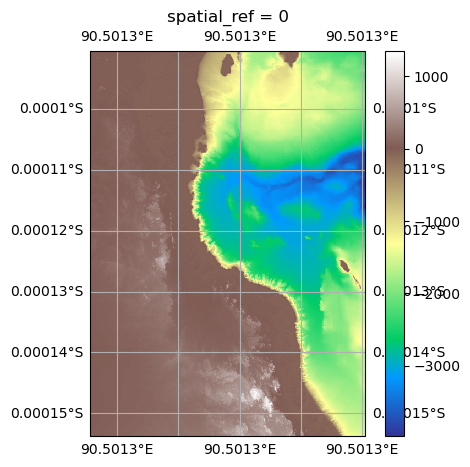

In [89]:
# need to sort out map projection and plot spacing
map_proj = ccrs.Mercator(central_longitude=90.5)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection=map_proj)
test.plot(ax=ax, cmap=plt.cm.terrain, vmin=float(test.min().values), vmax=float(test.max().values))
plot_borders(ax)
ax.gridlines(draw_labels=True)

In [65]:
fig = pl.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection=map_proj)
plot_dem(ax)
plot_borders(ax)
ax.set_extent([88, 93, 20, 27], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)

test.plot(cmap=plt.cm.terrain, vmin=float(test.min().values), vmax=float(test.max().values))
# could get nice formatting from Peisong here

NameError: name 'pl' is not defined

In [ ]:
tif_array.rxr.write_crs("WGS84", inplace=True)

In [ ]:
test.rio.reproject(tif_array.rxr.crs, resolution=1)

In [ ]:
coarse_test = data.upsample_xarray(test, {"longitude": 10000, "latitude": 10000})

In [ ]:
coarse_test.plot(x='longitude', y='latitude', figsize=(6,4))

In [ ]:
# p = coarse_test.plot(
#     subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
#     transform=ccrs.PlateCarree()
# )

# p.axes.set_global()
# p.axes.coastlines()

In [ ]:
def tif_to_gdf(xa_array: xa.DataArray, name: str = "xa_array") -> gpd.GeoDataFrame:
    """TODO: function to line tif files up with world map"""

    df = xa_array.to_dataframe(name=name).reset_index()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=xa_array.crs)

    # # Reproject the GeoDataFrame to Web Mercator
    # area_gdf = area_gdf.to_crs(epsg=3857)

    return gdf

In [ ]:
tif_to_gdf(gbr_30_dict['Great_Barrier_Reef_A_2020_30m_MSL_cog.tif'], name='Great_Barrier_Reef_A_2020_30m')

In [ ]:
display_xa_array(gbr_a)

In [ ]:
gbr_a_coarse.plot(cmap='gist_earth', vmin=min_val, vmax=max_val)

In [ ]:
gbr_a_coarse[0, -50:, -50:].plot(cmap='gist_earth', vmin=min_val, vmax=max_val)

In [ ]:
gbr_a[0, -5000:, -5000:].plot(cmap='gist_earth', vmin=min_val, vmax=max_val)

In [ ]:
gbr_a.plot()

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale("10m"))
ax.add_feature(cfeature.OCEAN.with_scale("10m"))

gbr_a.plot()


In [ ]:



def align_tifs_to_worldmap(tifs_dict: dict) -> gpd.GeoDataFrame:
    """TODO: docstring"""
    
    gdf_list = []
    for tif_name, tif_array in tifs_dict:
        bbox_gdf = align_tifs_to_worldmap(tif_array)
        gdf_list.append(bbox_gdf)

    all_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)	
    return all_gdf


def tif_to_gdf(xa_array) -> gpd.GeoDataFrame:
    """TODO: function to line tif files up with world map"""

    # Create GeoDataFrame with extent of the raster
    xmin, ymin, xmax, ymax = xa_array.bounds
    area_gdf = gpd.GeoDataFrame({'geometry': gpd.box(xmin, ymin, xmax, ymax)}, index=[0], crs=xa_array.crs)

    # Reproject the GeoDataFrame to Web Mercator
    area_gdf = area_gdf.to_crs(epsg=3857)

    return area_gdf


# def display_gdf_on_worldmap(gdf: gpd.GeoDataFrame) -> None:
    

# function to return pixel values closest to the shoreline
def return_pixels_closest_to_value(
    array: np.ndarray, 
    central_value: float, 
    tolerance: float = .5, 
    buffer_pixels: int = 10,
    bathymetry_only: bool = True
    ) -> np.ndarray:
    """Returns a 1D array of all the pixels in the input array that are closest to a specified central value within a 
    given tolerance and within a pixel buffer zone.

       Parameters
    ----------
    array (np.ndarray): The input array of pixel values.
    central_value (float): The central value to which the pixels should be compared.
    tolerance (float, optional): The tolerance within which the pixels are considered to be "close" to the central 
        value. Defaults to 0.5.
    buffer_pixels (int, optional): The size of the buffer zone around the pixels. Defaults to 10.
    bathymetry_only (bool, optional): Whether to only consider bathymetric data, i.e., values less than zero. 
        Defaults to True.

    Returns
    -------
    np.ndarray: A 1D array of all the pixels in the input array that are closest to the specified central value within 
        the given tolerance and within the pixel buffer zone.
    """
    binary = np.isclose(array, central_value, atol=0.5)
    # morphological dilation operation
    dilated = binary_dilation(binary, iterations=buffer_pixels)

    array_vals = array[dilated]
    # if specifying only bathymetric data
    if bathymetry_only:
        array_vals = array_vals[array_vals < 0]
    
    # return only non-zero values as 1d array
    return array_vals[np.nonzero(array_vals)]


def return_distance_closest_to_value(
    array: np.ndarray, 
    central_value: float, 
    tolerance: float = .5, 
    buffer_distance: float = 300,
    distance_per_pixel: float = 30,
    bathymetry_only: bool = True,
) -> np.ndarray:
    """Wrapper for return_pixels_closest_to_value() allowing specification by distance from thresholded values rather 
    than number of pixels
    
    Returns a 1D array of all the pixels in the input array that are closest to a specified central value within a 
    given tolerance and within a distance buffer zone.

       Parameters
    ----------
    array (np.ndarray): The input array of pixel values.
    central_value (float): The central value to which the pixels should be compared.
    tolerance (float, optional): The tolerance within which the pixels are considered to be "close" to the central 
        value. Defaults to 0.5.
    buffer_distance (float, optional): The size of the buffer zone around the pixels. Defaults to 300.
    bathymetry_only (bool, optional): Whether to only consider bathymetric data, i.e., values less than zero. 
        Defaults to True.

    Returns
    -------
    np.ndarray: A 1D array of all the pixels in the input array that are closest to the specified central value within 
        the given tolerance and within the distance buffer zone.
    """
    buffer_pixels = buffer_distance / distance_per_pixel
    return return_pixels_closest_to_value(array, central_value, tolerance, buffer_pixels, bathymetry_only)

In [ ]:
# plt.imshow(gbr_a_data[0:10000, 0:10000])
plt.imshow(gbr_a_data)
plt.show()

In [ ]:
binary = np.isclose(data_array[0], 0, atol=0.5)

In [ ]:
sum(sum(binary))

In [ ]:
from scipy.ndimage import binary_dilation

# Perform a morphological dilation operation
buffer_size = 10  # Define the buffer size
struct_elem = np.ones((buffer_size, buffer_size))  # Define the structuring element
dilated = binary_dilation(binary, iterations=buffer_size)

In [ ]:
plt.figure(figsize = (15,10))
plt.imshow(dilated)

In [ ]:
plt.figure(figsize = (15,10))
plt.imshow(shoreline)

In [ ]:
out = return_pixels_closest_to_value(data_array[0].values, 0, buffer_pixels=1)

In [ ]:
out
shallow_out = out[out > -100]

In [ ]:
plt.hist(out,100);

In [ ]:
# function to plot histogram of values

fig, ax = plt.subplots()
xa.plot.hist(data_array, ax=ax, bins=100)
ax.set_xlabel("depth")
ax.set_ylabel("counts")
ax.set_title("Histogram of DEM counts for selected area")

In [ ]:
## module import error
import gdal
# ds = gdal.Open('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif')
# channel = np.array(ds.GetRasterBand(1).ReadAsArray())

In [ ]:
data_array[0, :1000, :1000].plot(x='longitude', y='latitude', figsize=(6,4))

In [ ]:
# df = data_array[0].to_dataframe(name='asdf').reset_index()
# gdf = gpd.GeoDataFrame(df.value_column, geometry=gpd.points_from_xy(df.y,df.x))


In [ ]:
plot.gdf()

In [ ]:
bbox_gdf

In [ ]:
plot.bbox_gdf()

In [ ]:
# Create plot – TODO: update with custom bounds
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster on the GeoDataFrame extent
rasterio.plot.show(bbox_gdf, ax=ax)

In [ ]:
# function to line tif files up with world map



In [ ]:
nc_dir = '/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/ETOPO22'
name = 'ETOPO_2022_v1_15s_N00E000_geoid.nc'

Path(nc_dir, name)

In [ ]:
def merge_nc_files(nc_dir: Path | str, file_names: list[str]) -> xa.Dataset:
	files = [Path(nc_dir, file_name) for file_name in file_names]
	merged_ncs = xa.open_mfdataset(files)
	return merged_ncs

In [ ]:
file_names = ["ETOPO_2022_v1_15s_N00E000_geoid.nc", "ETOPO_2022_v1_15s_N00E015_geoid.nc", "ETOPO_2022_v1_15s_N00E030_geoid.nc"]
# bathy_xa = xa.open_dataset('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/ETOPO22/ETOPO_2022_v1_15s_N00E000_geoid.nc')
out = merge_nc_files(nc_dir, file_names)

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Add a global map background
ax.stock_img()

out['z'].plot(ax=ax, x='lon', y='lat')

## Webscraping data: really not a priority

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time

# Set up the Selenium driver with Chrome
driver = webdriver.Chrome('/path/to/chromedriver')

# Navigate to the webpage with the download button
driver.get('https://example.com/download-page')

# Wait for the page to fully load
time.sleep(5)

# Find the download button using its text or other identifying feature
download_button = driver.find_element_by_xpath('//button[text()="Download"]')

# Click the button to trigger the download link generation
download_button.click()

# Wait for the download link to be generated
time.sleep(5)

# Get the page source with the download link
page_source = driver.page_source

# Parse the page source with BeautifulSoup to extract the download link
soup = BeautifulSoup(page_source, 'html.parser')
download_link = soup.find('a', {'class': 'download-link'})['href']

# Download the file using the extracted download link
# ... (your code to download the file)

In [ ]:
# rich progress bar I couldn't get working
# import urllib.request
# from rich.progress import Progress, BarColumn, DownloadColumn, TransferSpeedColumn, TimeRemainingColumn


# class DownloadProgressBar:
#     def __init__(self, unit='B'):
#         self.progress = Progress(
#             "{task.description}",
#             BarColumn(),
#             DownloadColumn(),
#             TransferSpeedColumn(),
#             TimeRemainingColumn(),
#         )
#         self.unit = unit

#     def __enter__(self):
#         self.task_id = self.progress.add_task("", start=False)
#         self.progress.start()
#         return self

#     def __exit__(self, *exc_info):
#         self.progress.stop()

#     def update_to(self, b=1, bsize=1, tsize=None):
#         if tsize is not None:
#             # Convert the total size to the specified unit
#             total_size = tsize / self.unit_size
#             self.progress.update(self.task_id, total=total_size)
#         self.progress.update(self.task_id, advance=b * bsize / self.unit_size)

#     @property
#     def unit_size(self):
#         # Return the size of one unit in bytes
#         if self.unit == 'B':
#             return 1
#         elif self.unit == 'KB':
#             return 1024
#         elif self.unit == 'MB':
#             return 1024 * 1024
#         elif self.unit == 'GB':
#             return 1024 * 1024 * 1024
#         else:
#             raise ValueError(f"Invalid unit: {self.unit}")

# def download_url(url, output_path, progress_units: str = 'MB'):
#     print("\n")
#     with DownloadProgressBar(progress_units) as t:
#         urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)
